In [1]:
# import
import keras
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import SimpleRNN, Dense
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import model_selection
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import h5py as h5py

/usr/lib64/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
BINARY = False
timestep = 1
epochs = 10
en_corpus_file = "corpus-en.txt"
ewo_corpus_file = "corpus-ewo.txt"
best_model_file = "best-model-conll.hdfs"
max_nb_of_phrases =  -1
duplication = 1
max_depth = 0
is_only_vocab = True
time_history_default = None
time_history_autoencoder = None

In [3]:
with_encoding = True

In [4]:
def getTag(aString):
    tag = "O"
    if BINARY:
        if aString != "O":
            return "NE"
    else:
        tag = aString
    return tag
     

In [5]:
def load_corpus(file, max_nb_of_phrases):
    nb_of_phrases = 0
    dataset = {"word": [], "ne-tag": []}
    with open(file) as f:
        prev_line = None
        for cpt, line in enumerate(f):
            if cpt == 0:
                continue
            if nb_of_phrases == max_nb_of_phrases:
                break;

            l = line.strip()
            if len(l) == 0 and len(prev_line) != 0:
                nb_of_phrases += 1
                dataset["word"].append(line)
                dataset["ne-tag"].append(None)
            else:
                l = l.split("\t")
                dataset["word"].append(l[0])
                dataset["ne-tag"].append(ne_type(l[1]))
            prev_line = line.strip()
        
    return pd.DataFrame(dataset), nb_of_phrases+1

In [6]:
def corpus_fingerprint(aDataframe, nb_of_biphrases):
    # create distributionnal signature
    fingerprints = {}
    current_bi_phrase_index = 0
    for index, row in aDataframe.iterrows():
        if current_bi_phrase_index > nb_of_biphrases:
            break
            
        word = row['word']
        
        if word != "\n":
            if word not in fingerprints:
                fingerprints[word] = np.zeros(nb_of_biphrases, dtype=np.int8)
            fingerprints[word][current_bi_phrase_index] = 1
        else:
            current_bi_phrase_index += 1
    return pd.DataFrame(fingerprints)

In [7]:
def corpus2trainingdata(aDataframe, fingerprintsDataFrame):
    X = np.zeros((aDataframe.shape[0], fingerprintsDataFrame.shape[0]), dtype=np.int8)
    y = np.zeros(aDataframe.shape[0], dtype=np.int8)
    i = 0
    for row in aDataframe.iterrows():
        X[i] = fingerprintsDataFrame[row[1]['word']].values
        y[i] = tag2int[getTag(row[1]['ne-tag'])]
        i += 1
    return X, y

In [8]:
def train_test_split(X, y, test_size = 0.33):
    total = X.shape[0]
    train_length = round(total * (1 - test_size)) 
    return X[:train_length], X[train_length:], y[:train_length], y[train_length:]

In [9]:
  
def ne_type(aType):
    aType = aType.lower()
    if 'per' in aType:
        t =  'NE' if BINARY else 'PER' 
    elif 'loc' in aType:
        t =  'NE' if BINARY else 'LOC'
    elif 'org' in aType:
        t =  'NE' if BINARY else 'ORG'
    elif 'hour' in aType:
        t =  'NE' if BINARY else 'MISC'
    elif aType != 'o' and len(aType) > 0 :
        t =  'NE' if BINARY else 'MISC'
    else:
        t = 'O'
    return t

In [10]:
def compute_performance(y_true, y_pred, words=None, BINARY=False):
    if BINARY:
        p = precision_score(y_true, y_pred, pos_label=tag2int['NE'])
        r = recall_score(y_true, y_pred, pos_label=tag2int['NE'])
        f1 = f1_score(y_true, y_pred, pos_label=tag2int['NE'])
        acc = accuracy_score(y_true, y_pred)
    else:
        p = precision_score(y_pred, y_true, average='macro')
        r = recall_score(y_pred, y_true, average='macro')
        f1 = f1_score(y_pred, y_true, average='macro')
        acc = accuracy_score(y_pred, y_true)
    if words is None:
        model_output_vs = pd.DataFrame({'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})
    else:
        model_output_vs = pd.DataFrame({'word': words, 'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})

    return p, r, f1, acc, model_output_vs

In [11]:
def P_R_F1(y_pred, y_true, neg_class):
    same = y_pred[y_true==y_pred]
    tp = same[same != neg_class].size
    nb_of_pos_exple = y_true[y_true != neg_class].size
    nb_of_pos_pred = y_pred[y_pred != neg_class].size
    p = r = f1 = 0
    try:
        p = np.round(tp*100/nb_of_pos_pred, 2)
    except ZeroDivisionError:
        print("number of correct positive predictions is 0")
        
    try:
        r = np.round(tp*100/nb_of_pos_exple, 2)
    except ZeroDivisionError:
        print("number of position exple is 0")
        
    try:
        f1 = np.round(2*r*p/(r+p), 2)
    except ZeroDivisionError:
        print("Recall and precision are 0")

    return p, r, f1

In [12]:
def is_mergeable(aListOfConsecutiveTokens, corpus, fingerprints):
    n = len(aListOfConsecutiveTokens)
    if n <= 1:
        return False
    if n == 2:
        w1, w2 = aListOfConsecutiveTokens[0], aListOfConsecutiveTokens[1]
        rep1, rep2 = fingerprints[aListOfConsecutiveTokens[0]], fingerprints[aListOfConsecutiveTokens[1]]
        tag1, tag2 = corpus[corpus.word==w1].iloc[0]['ne-tag'], corpus[corpus.word==w2].iloc[0]['ne-tag']
        if (tag1 == tag2) and (tag1 == "O"): # O + O => False
            return False
        if (tag1 != tag2) and (tag1 != "O") and (tag2 != "O"): # X + Y => False
            return False
        return rep1.equals(rep2)
    else:
        half = int(n / 2)
        return is_mergeable(aListOfConsecutiveTokens[0:half+1], corpus, fingerprints) and is_mergeable(aListOfConsecutiveTokens[half:n], corpus, fingerprints)

In [13]:
def merge(depth, corpus, fingerprint):
    wordDf = corpus[corpus.word != "\n"].word
    nbOfWord = wordDf.shape[0]
    text = list(wordDf)
    X2, target2, tokens = [], [], []
    level, newToken = 1, True
    while level <= depth and newToken:
        i, newToken = 0, False
        limit = nbOfWord - level
        while i < limit:
            if is_mergeable(text[i:i+level+1], corpus, fingerprint):
                tokens.append(" ".join(text[i:i+level+1]))
                newToken = True
            i += 1
        print("level ", level, ":", set(tokens))
        level += 1
    
    X2, target2 = np.array(X2), np.array(target2)
    
    return X2, target2, set(tokens)

In [14]:
def shuffle(X, y):
    indices = [i for i in  range(X.shape[0])]
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [15]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [16]:
from keras.layers import Input

def create_and_train_autoencoder(X_train, code_dim, epochs=10):
    input_data = Input(shape=(X_train.shape[1],))
    encoded = Dense(code_dim, activation="sigmoid")(input_data)
    decoded = Dense(X_train.shape[1], activation="sigmoid")(encoded)
    
    encoder = Model(input_data, encoded)
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer="sgd", loss="binary_crossentropy")
    autoencoder.fit(X_train, X_train, shuffle=True, epochs=epochs, validation_data=(X_train, X_train))
    
    return encoder

In [17]:
en_corpus, en_nb_of_phrases = load_corpus(en_corpus_file, max_nb_of_phrases)

In [18]:
tagSet = en_corpus["ne-tag"].dropna().unique()
if BINARY:
    tagSet = ['NE', 'O']
tag2int = {j: i for i, j in enumerate(tagSet)}
int2tag = {i: j for i, j in enumerate(tagSet)}
print(tag2int)

{'O': 0, 'MISC': 1, 'PER': 2, 'LOC': 3, 'ORG': 4}


In [19]:
en_nb_of_phrases

210

In [20]:
en_corpus.describe()

,ne-tag,word
count,4753,4962
unique,5,913
top,O,","
freq,4362,343


In [21]:
en_corpus.head(10)

,ne-tag,word
0,O,The
1,O,Promise
2,O,of
3,O,the
4,MISC,Holy
5,MISC,Spirit
6,None,\n
7,O,In
8,O,the
9,O,first


In [22]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 87.91 %
MISC % = 2.12 %
PER % = 4.94 %
LOC % = 0.81 %
ORG % = 0.02 %


In [23]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.27 %
MISC % = 1.86 %
PER % = 8.87 %
LOC % = 1.97 %
ORG % = 0.11 %


In [24]:
en_corpus[en_corpus.word == "\n"].shape

(209, 2)

In [25]:
print("Nb of bi-phrases", en_nb_of_phrases)
en_fingerprints = corpus_fingerprint(en_corpus, en_nb_of_phrases)

Nb of bi-phrases 210


In [26]:
en_corpus[en_corpus.word != "\n"].shape

(4753, 2)

In [27]:
X2, target2, tokens = merge(max_depth, en_corpus, en_fingerprints)

In [28]:
if is_only_vocab:
    text = list(en_corpus[en_corpus.word != "\n"].word.unique())
else:
    text = list(en_corpus[en_corpus.word != "\n"].word)
en_vocab = pd.DataFrame({'text': text + list(tokens)})
en_vocab.describe()

,text
count,912
unique,912
top,'The
freq,1


In [29]:
if is_only_vocab:
    X = np.zeros((en_vocab.shape[0] * duplication, en_nb_of_phrases))
    target = np.zeros((en_vocab.shape[0] * duplication))
    p=0
    for i, row in en_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X[p] = en_fingerprints[c.split(" ")[0]]
            target[p] = tag2int[getTag(en_corpus[en_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X, target = shuffle(X, target)
    print(X.shape, en_fingerprints.shape, target.shape)

(912, 210) (210, 912) (912,)


In [30]:
en_vocab[-20:]

,text
892,Eliud
893,Eleazar
894,Matthan
895,husband
896,fourteen
897,unwilling
898,shame
899,resolved
900,divorce
901,quietly


In [31]:
if not is_only_vocab:
    X, target = corpus2trainingdata(en_corpus[en_corpus.word != "\n"], en_fingerprints)

In [32]:
print(X.shape, target.shape)
if len(X.shape) == len(X2.shape):
    X = np.concatenate((X, X2))
    target = np.concatenate((target, target2))
    X, target = shuffle(X, target)
print(X.shape, target.shape)

(912, 210) (912,)
(912, 210) (912,)


In [33]:
#encoding
encoder = None
if with_encoding:
    encoder = create_and_train_autoencoder(X_train=X, code_dim=105, epochs=20)

Train on 912 samples, validate on 912 samples
Epoch 1/20
912/912 [==============================] - 0s 205us/step - loss: 0.6866 - val_loss: 0.6821
Epoch 2/20
912/912 [==============================] - 0s 104us/step - loss: 0.6781 - val_loss: 0.6737
Epoch 3/20
912/912 [==============================] - 0s 137us/step - loss: 0.6698 - val_loss: 0.6655
Epoch 4/20
912/912 [==============================] - 0s 117us/step - loss: 0.6617 - val_loss: 0.6574
Epoch 5/20
912/912 [==============================] - 0s 100us/step - loss: 0.6537 - val_loss: 0.6495
Epoch 6/20
912/912 [==============================] - 0s 101us/step - loss: 0.6458 - val_loss: 0.6417
Epoch 7/20
912/912 [==============================] - 0s 102us/step - loss: 0.6380 - val_loss: 0.6340
Epoch 8/20
912/912 [==============================] - 0s 105us/step - loss: 0.6305 - val_loss: 0.6265
Epoch 9/20
912/912 [==============================] - 0s 98us/step - loss: 0.6230 - val_loss: 0.6191
Epoch 10/20
912/912 [================

In [34]:
X_encoded = X.copy()
if with_encoding:
    X_encoded = encoder.predict(X)
    print(X_encoded[0])

[0.5010538  0.5199639  0.4737534  0.52320796 0.47564256 0.4860164
 0.5240697  0.4661537  0.514448   0.47302967 0.485101   0.47416255
 0.5182444  0.5270213  0.4951151  0.5332668  0.4826507  0.49870887
 0.48076454 0.49909675 0.48698178 0.5241947  0.512829   0.50001186
 0.49207127 0.48856372 0.4942264  0.48658746 0.5177445  0.49236965
 0.47789487 0.50547916 0.5054161  0.51976484 0.5197955  0.5245732
 0.4702894  0.4847364  0.47987992 0.52928823 0.47252893 0.49416646
 0.5258123  0.47891164 0.52332985 0.50714856 0.49364102 0.49662924
 0.4970579  0.47251898 0.5279611  0.46865606 0.49206945 0.51863617
 0.47213987 0.52018005 0.47855583 0.53179616 0.47714448 0.50584507
 0.51492405 0.4991513  0.5107546  0.47312912 0.4979839  0.4807723
 0.5229389  0.48166472 0.49972653 0.5100054  0.46705428 0.4916456
 0.4862315  0.5317805  0.48293808 0.47212243 0.50023955 0.49912018
 0.46805516 0.5124829  0.49893966 0.5027977  0.4673353  0.5294722
 0.5340996  0.4720932  0.5139049  0.48675826 0.50410914 0.5067928
 

In [35]:
y = target.copy()
y[0:100]
if not BINARY:
    y = np_utils.to_categorical(y, len(tagSet))
y.shape

(912, 5)

In [36]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_encoded, y, test_size=0.33)
X_train = X_train.reshape(X_train.shape[0], timestep, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], timestep, X_val.shape[1])
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_val.shape =", X_val.shape)
print("y_val.shape =", y_val.shape)

tTarget = np.array([np.argmax(yy) for yy in y_train])
vTarget = np.array([np.argmax(yy) for yy in y_val])

for tag in tagSet:
    print("{0} % in training data = {1} %".format(tag, np.round(tTarget[tTarget==tag2int[tag]].size * 100 / tTarget.shape[0], 2)))
    print("{0} % in validation data = {1} %".format(tag, np.round(vTarget[vTarget==tag2int[tag]].size * 100 / vTarget.shape[0], 2)))

X_train.shape = (611, 1, 105)
y_train.shape = (611, 5)
X_val.shape = (301, 1, 105)
y_val.shape = (301, 5)
O % in training data = 88.22 %
O % in validation data = 88.7 %
MISC % in training data = 0.65 %
MISC % in validation data = 2.33 %
PER % in training data = 9.0 %
PER % in validation data = 7.31 %
LOC % in training data = 2.13 %
LOC % in validation data = 1.33 %
ORG % in training data = 0.0 %
ORG % in validation data = 0.33 %


In [37]:
def create_model(input_dim, output_dim):
    model = Sequential()
    model.add(SimpleRNN(640, input_shape=(None, input_dim), activation='sigmoid'))
    model.add(Dense(160, activation='sigmoid'))
    if BINARY:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
    else:
        model.add(Dense(output_dim, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    return model

In [38]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=epochs):
    time_history_cb = TimeHistory()
    best_model_cp = ModelCheckpoint(best_model_file, save_best_only=True, verbose=2) # saved best model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[best_model_cp, time_history_cb])
    best_model = keras.models.load_model(best_model_file) #loading the best model
    return best_model, time_history_cb

In [39]:
def predict(model, X, y, binary=BINARY):
    if BINARY:
        y_pred = np.round(model.predict(X))
        y_true = y
    else:
        predictions = model.predict(X)
        y_pred = np.array([np.argmax(p) for p in predictions])
        y_true = np.array([np.argmax(t) for t in y ])
    return y_true, y_pred

In [40]:
def model_performance(y_true, y_pred):
    return P_R_F1(y_pred, y_true, tag2int['O']) #precision, recall, f1-score

In [41]:
def model_performace_by_tag(y_true, y_pred, tag):
    p, r, f1 = 0, 0, 0
    
    eq = y_pred[y_pred==y_true]
    correctly_pred = eq[eq==tag].size
    try:
        p = np.round(100 * correctly_pred / y_pred[y_pred==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        r = np.round(100 * correctly_pred / y_true[y_true==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        f1 = np.round(2 * r * p / (r + p), 2)
    except ZeroDivisionError:
        pass
    
    return p, r, f1

In [42]:
ewo_corpus, ewo_nb_of_phrases = load_corpus(ewo_corpus_file, max_nb_of_phrases)

In [43]:
ewo_nb_of_phrases

210

In [44]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 86.37 %
MISC % = 2.18 %
PER % = 5.76 %
LOC % = 0.89 %
ORG % = 0.05 %


In [45]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 90.0 %
MISC % = 1.17 %
PER % = 8.25 %
LOC % = 1.84 %
ORG % = 0.19 %


In [46]:
ewo_corpus.describe()

,ne-tag,word
count,4185,4394
unique,5,1030
top,O,","
freq,3795,413


In [47]:
ewo_corpus.head()

,ne-tag,word
0,MISC,Mfufub
1,MISC,Nsisim
2,O,ayi
3,O,sò
4,None,\n


In [48]:
ewo_fingerprints = corpus_fingerprint(ewo_corpus, en_nb_of_phrases)

In [49]:
X2, target2, tokens = merge(max_depth, ewo_corpus, ewo_fingerprints)

In [50]:
if is_only_vocab:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word.unique())
else:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word)
ewo_vocab = pd.DataFrame({"text":text + list(tokens)})

In [51]:
if is_only_vocab:
    X_ewo = np.zeros((ewo_vocab.shape[0] * duplication, en_nb_of_phrases))
    ewo_target = np.zeros((ewo_vocab.shape[0] * duplication))
    p=0
    for i, row in ewo_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X_ewo[p] = ewo_fingerprints[c.split(" ")[0]]
            ewo_target[p] = tag2int[getTag(ewo_corpus[ewo_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X_ewo, ewo_target = shuffle(X_ewo, ewo_target)

In [52]:
ewo_vocab[-20:]

,text
1009,nlo
1010,obë
1011,mbara
1012,yabyali
1013,dzili
1014,yasò
1015,oyolëge
1016,kode
1017,dili
1018,atoban


In [53]:
if not is_only_vocab:
    X_ewo, ewo_target = corpus2trainingdata(ewo_corpus[ewo_corpus.word != "\n"], ewo_fingerprints)

In [54]:
print(X_ewo.shape, ewo_target.shape)
if len(X_ewo.shape) == len(X2.shape):
    X_ewo = np.concatenate((X_ewo, X2))
    ewo_target = np.concatenate((ewo_target, target2))
    X_ewo, ewo_target = shuffle(X_ewo, ewo_target)
print(X_ewo.shape, ewo_target.shape)

(1029, 210) (1029,)
(1029, 210) (1029,)


In [55]:
X_ewo_encoded = X_ewo.copy()
if with_encoding:
    X_ewo_encoded = encoder.predict(X_ewo)
    print(X_ewo_encoded.shape)

(1029, 105)


In [56]:
y_ewo = ewo_target.copy()
print(y_ewo.shape, len(ewo_vocab))

(1029,) 1029


In [57]:
y_ewo = ewo_target.copy()
y_ewo[:20]
if not BINARY:
    y_ewo = np_utils.to_categorical(y_ewo)

In [58]:
X_ewo_encoded = X_ewo_encoded.reshape((X_ewo.shape[0], timestep, X_ewo_encoded.shape[1]))

In [59]:
def algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, epochs=epochs, model=None):
    test_precision, train_precision, ewo_precision = [], [], []
    test_recall, train_recall, ewo_recall = [], [], []
    test_fscore, train_fscore, ewo_fscore = [], [], []
    
    test_result_by_tag = {}
    train_result_by_tag = {}
    ewo_result_by_tag = {}
    for t in tagSet:
        f1_key = "F1-"+t
        p_key = "P-"+t
        r_key = "R-"+t
        train_result_by_tag[f1_key], train_result_by_tag[p_key], train_result_by_tag[r_key] = [], [], []
        test_result_by_tag[f1_key], test_result_by_tag[p_key], test_result_by_tag[r_key] = [], [], []
        ewo_result_by_tag[f1_key], ewo_result_by_tag[p_key], ewo_result_by_tag[r_key] = [], [], []

    m, time_history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
    y_true, y_pred = predict(m, X_train, y_train)
    p_train, r_train, f1_train = model_performance(y_true, y_pred)
        
    y_true_val, y_pred_val = predict(m, X_val, y_val)
    p_val, r_val, f1_val = model_performance(y_true_val, y_pred_val)
        
    y_true_ewo, y_pred_ewo = predict(m, X_ewo, y_ewo) 
    p_ewo, r_ewo, f1_ewo = model_performance(y_true_ewo, y_pred_ewo)
        
    for t in range(len(int2tag)):
        f1_key = "F1-" + int2tag[t]
        p_key = "P-" + int2tag[t]
        r_key = "R-" + int2tag[t]
            
        p, r, f1 = model_performace_by_tag(y_true, y_pred, t)
        train_result_by_tag[p_key].append(p)
        train_result_by_tag[r_key].append(r)
        train_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_val, y_pred_val, t)
        test_result_by_tag[p_key].append(p)
        test_result_by_tag[r_key].append(r)
        test_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_ewo, y_pred_ewo, t)
        ewo_result_by_tag[p_key].append(p)
        ewo_result_by_tag[r_key].append(r)
        ewo_result_by_tag[f1_key].append(f1)
                
    test_precision.append(p_val)
    train_precision.append(p_train)
    ewo_precision.append(p_ewo)
        
    test_recall.append(r_val)
    train_recall.append(r_train)
    ewo_recall.append(r_ewo)
        
    test_fscore.append(f1_val)
    train_fscore.append(f1_train)
    ewo_fscore.append(f1_ewo)
    return pd.DataFrame({
        'P_test': test_precision, 
        'P_train': train_precision, 
        'P_ewo': ewo_precision, 'R_test': test_recall, 'R_train': train_recall, 
        'R_ewo': ewo_recall, 'F1-test': test_fscore, 'F1-train': train_fscore, 'F1-ewo': ewo_fscore}), pd.DataFrame(train_result_by_tag), pd.DataFrame(test_result_by_tag), pd.DataFrame(ewo_result_by_tag), time_history

In [60]:
model = create_model(X_encoded.shape[1], len(tagSet))
if with_encoding:
    resultEval, train_by_tag, test_by_tag, ewo_by_tag, time_history_autoencoder = algoEval(X_train, y_train, X_val, y_val, X_ewo_encoded, y_ewo, model=model, epochs=50)
    pd.DataFrame(time_history_autoencoder.times).to_csv("time_history_autoencoder.csv")
else:
    resultEval, train_by_tag, test_by_tag, ewo_by_tag, time_history_default = algoEval(X_train, y_train, X_val, y_val, X_ewo_encoded, y_ewo, model=model, epochs=50)
    pd.DataFrame(time_history_default.times).to_csv("time_history_default.csv")

Train on 611 samples, validate on 301 samples
Epoch 1/50
611/611 [==============================] - 1s 913us/step - loss: 0.5367 - acc: 0.8822 - val_loss: 0.5341 - val_acc: 0.8870
Epoch 2/50
611/611 [==============================] - 1s 928us/step - loss: 0.4697 - acc: 0.8822 - val_loss: 0.5620 - val_acc: 0.8870
Epoch 3/50
611/611 [==============================] - 0s 790us/step - loss: 0.4770 - acc: 0.8822 - val_loss: 0.5288 - val_acc: 0.8870
Epoch 4/50
611/611 [==============================] - 1s 1ms/step - loss: 0.4699 - acc: 0.8822 - val_loss: 0.5194 - val_acc: 0.8870
Epoch 5/50
611/611 [==============================] - 0s 712us/step - loss: 0.4635 - acc: 0.8822 - val_loss: 0.6283 - val_acc: 0.8870
Epoch 6/50
611/611 [==============================] - 0s 782us/step - loss: 0.4627 - acc: 0.8822 - val_loss: 0.5064 - val_acc: 0.8870
Epoch 7/50
611/611 [==============================] - 0s 805us/step - loss: 0.4552 - acc: 0.8822 - val_loss: 0.7351 - val_acc: 0.8870
Epoch 8/50
611/611

611/611 [==============================] - 0s 751us/step - loss: 0.4469 - acc: 0.8822 - val_loss: 0.5125 - val_acc: 0.8870
Epoch 33/50
611/611 [==============================] - 0s 723us/step - loss: 0.4472 - acc: 0.8822 - val_loss: 0.5111 - val_acc: 0.8870
Epoch 34/50
611/611 [==============================] - 1s 885us/step - loss: 0.4455 - acc: 0.8822 - val_loss: 0.5093 - val_acc: 0.8870
Epoch 35/50
611/611 [==============================] - 0s 739us/step - loss: 0.4450 - acc: 0.8822 - val_loss: 0.5095 - val_acc: 0.8870
Epoch 36/50
611/611 [==============================] - 1s 896us/step - loss: 0.4455 - acc: 0.8822 - val_loss: 0.5098 - val_acc: 0.8870
Epoch 37/50
611/611 [==============================] - 1s 857us/step - loss: 0.4444 - acc: 0.8822 - val_loss: 0.5102 - val_acc: 0.8870
Epoch 38/50
611/611 [==============================] - 0s 703us/step - loss: 0.4460 - acc: 0.8822 - val_loss: 0.5116 - val_acc: 0.8870
Epoch 39/50
611/611 [==============================] - 0s 784us/ste

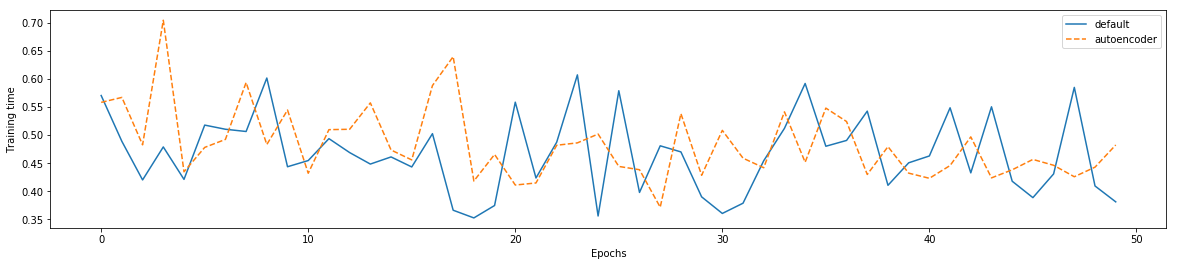

In [61]:
try:
    time_history_default = pd.read_csv("time_history_default.csv", usecols=[1])["0"].values.tolist()
    time_history_autoencoder = pd.read_csv("time_history_autoencoder.csv", usecols=[1])["0"].values.tolist()
    figure, axis = plt.subplots(figsize=(20, 4))
    axis.plot(time_history_default, label="default")
    axis.plot(time_history_autoencoder, ls="--", label="autoencoder")
    axis.set_ylabel("Training time")
    axis.set_xlabel("Epochs")
    axis.legend()
    figure.savefig(fname="time-by-epochs.png")
except FileNotFoundError as e:
    print("file not found", e)

In [63]:
# resultEval

In [64]:
# train_b`y_tag

In [65]:
# test_by_tag

In [66]:
# ewo_by_tag

In [67]:
# resultEval.mean()

In [68]:
# resultEval.std()

In [69]:
def algoCrossVal(model, X, y, X_ewo, y_ewo, k = 10, repeat=1): 
    block_size = int(X.shape[0] / 4)   
    output = None
    train_by_tags, test_by_tags, ewo_by_tags = None, None, None
    for it in range(repeat):
        print("AlgoCrossValIter -", it+1)
        model = create_model(X.shape[1], len(tagSet))
        results = None
        train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = None, None, None
        for i in range(k):
            X_val, y_val = X[i*block_size:i*block_size+block_size], y[i*block_size:i*block_size+block_size]
            X_train = np.concatenate((X[0:i*block_size], X[i*block_size+block_size:]))
            y_train = np.concatenate((y[0:i*block_size], y[i*block_size+block_size:]))

            X_train = X_train.reshape(X_train.shape[0], timestep, X_train.shape[1])
            X_val = X_val.reshape(X_val.shape[0], timestep, X_val.shape[1])

            result, train_by_tag, test_by_tag, ewo_by_tag, thistory = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)
            if results is None:
                results = result.copy()
                train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = train_by_tag.copy(), test_by_tag.copy(), ewo_by_tag.copy()
            else:
                results = pd.concat([results, result], ignore_index=True)
                train_by_tagsTmp = pd.concat([train_by_tagsTmp, train_by_tag], ignore_index=True)
                test_by_tagsTmp = pd.concat([test_by_tagsTmp, test_by_tag], ignore_index=True)
                ewo_by_tagsTmp = pd.concat([ewo_by_tagsTmp, ewo_by_tag], ignore_index=True)
        
        if output is None:
            output = results.mean(axis=0).to_frame()
            train_by_tags = train_by_tagsTmp.mean(axis=0).to_frame()
            test_by_tags = test_by_tagsTmp.mean(axis=0).to_frame()
            ewo_by_tags = ewo_by_tagsTmp.mean(axis=0).to_frame()
        else:
            output = pd.concat([output, results.mean(axis=0).to_frame()], axis=1)
            train_by_tags = pd.concat([train_by_tags, train_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            test_by_tags = pd.concat([test_by_tags, test_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            ewo_by_tags = pd.concat([ewo_by_tags, ewo_by_tagsTmp.mean(axis=0).to_frame()], axis=1)

    return output, train_by_tags, test_by_tags, ewo_by_tags

In [70]:
m = create_model(X_encoded.shape[1], len(tagSet))
resultCrossVal, trainByTagResult, testByTagResult, ewoByTagResult = algoCrossVal(m, X_encoded, y, X_ewo_encoded, y_ewo, repeat=10)

AlgoCrossValIter - 1
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 895us/step - loss: 0.5332 - acc: 0.8582 - val_loss: 0.4850 - val_acc: 0.8816
Epoch 2/10
684/684 [==============================] - 1s 926us/step - loss: 0.4727 - acc: 0.8845 - val_loss: 0.5111 - val_acc: 0.8816
Epoch 3/10
684/684 [==============================] - 0s 653us/step - loss: 0.4770 - acc: 0.8845 - val_loss: 0.4965 - val_acc: 0.8816
Epoch 4/10
684/684 [==============================] - 0s 654us/step - loss: 0.4750 - acc: 0.8845 - val_loss: 0.5622 - val_acc: 0.8816
Epoch 5/10
684/684 [==============================] - 0s 652us/step - loss: 0.4644 - acc: 0.8845 - val_loss: 0.4675 - val_acc: 0.8816
Epoch 6/10
684/684 [==============================] - 1s 752us/step - loss: 0.4601 - acc: 0.8845 - val_loss: 0.4670 - val_acc: 0.8816
Epoch 7/10
684/684 [==============================] - 1s 918us/step - loss: 0.4597 - acc: 0.8845 - val_loss: 0.4898 - val_acc: 0.

number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 865us/step - loss: 0.4587 - acc: 0.8874 - val_loss: 0.4798 - val_acc: 0.8728
Epoch 2/10
684/684 [==============================] - 0s 635us/step - loss: 0.4586 - acc: 0.8874 - val_loss: 0.4804 - val_acc: 0.8728
Epoch 3/10
684/684 [==============================] - 1s 758us/step - loss: 0.4562 - acc: 0.8874 - val_loss: 0.4948 - val_acc: 0.8728
Epoch 4/10
684/684 [==============================] - 1s 836us/step - loss: 0.4582 - acc: 0.8874 - val_loss: 0.4837 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 1s 761us/step - loss: 0.4559 - acc: 0.8874 - val_loss: 0.4823 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 0s 653us/step - loss: 0.4559 - acc: 0.8874 - val_loss: 0.4830 - val_acc: 0.8728
Epoch 7/10
684/684

/usr/lib64/python3.6/site-packages/keras/callbacks.py:403: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


912/912 [==============================] - 1s 658us/step - loss: 0.4608 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 721us/step - loss: 0.4615 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 0s 537us/step - loss: 0.4607 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 1s 561us/step - loss: 0.4604 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 618us/step - loss: 0.4596 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 584us/step - loss: 0.4600 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 633us/step - loss: 0.4613 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 571us/step - loss: 0.4594 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 611us/step - loss: 0.4596 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precisio

Epoch 5/10
684/684 [==============================] - 0s 710us/step - loss: 0.4705 - acc: 0.8845 - val_loss: 0.4794 - val_acc: 0.8816
Epoch 6/10
684/684 [==============================] - 0s 622us/step - loss: 0.4648 - acc: 0.8845 - val_loss: 0.4701 - val_acc: 0.8816
Epoch 7/10
684/684 [==============================] - 1s 818us/step - loss: 0.4588 - acc: 0.8845 - val_loss: 0.4783 - val_acc: 0.8816
Epoch 8/10
684/684 [==============================] - 0s 726us/step - loss: 0.4626 - acc: 0.8845 - val_loss: 0.4714 - val_acc: 0.8816
Epoch 9/10
684/684 [==============================] - 0s 584us/step - loss: 0.4558 - acc: 0.8845 - val_loss: 0.4734 - val_acc: 0.8816
Epoch 10/10
684/684 [==============================] - 1s 771us/step - loss: 0.4581 - acc: 0.8845 - val_loss: 0.4630 - val_acc: 0.8816
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/68

Epoch 4/10
684/684 [==============================] - 1s 778us/step - loss: 0.4589 - acc: 0.8874 - val_loss: 0.4799 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 0s 696us/step - loss: 0.4576 - acc: 0.8874 - val_loss: 0.4811 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 1s 881us/step - loss: 0.4557 - acc: 0.8874 - val_loss: 0.4850 - val_acc: 0.8728
Epoch 7/10
684/684 [==============================] - 0s 672us/step - loss: 0.4569 - acc: 0.8874 - val_loss: 0.4816 - val_acc: 0.8728
Epoch 8/10
684/684 [==============================] - 1s 853us/step - loss: 0.4583 - acc: 0.8874 - val_loss: 0.4842 - val_acc: 0.8728
Epoch 9/10
684/684 [==============================] - 0s 649us/step - loss: 0.4574 - acc: 0.8874 - val_loss: 0.4811 - val_acc: 0.8728
Epoch 10/10
684/684 [==============================] - 1s 857us/step - loss: 0.4559 - acc: 0.8874 - val_loss: 0.4834 - val_acc: 0.8728
number of correct positive predictions is 0
number of correct

912/912 [==============================] - 1s 610us/step - loss: 0.4560 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 638us/step - loss: 0.4575 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 1s 700us/step - loss: 0.4563 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 652us/step - loss: 0.4541 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 725us/step - loss: 0.4578 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 0s 537us/step - loss: 0.4575 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 807us/step - loss: 0.4576 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 641us/step - loss: 0.4572 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
AlgoCrossValIter - 3
Train on 684 samples, va

684/684 [==============================] - 0s 687us/step - loss: 0.4753 - acc: 0.8757 - val_loss: 0.4042 - val_acc: 0.9079
Epoch 7/10
684/684 [==============================] - 1s 900us/step - loss: 0.4756 - acc: 0.8757 - val_loss: 0.4248 - val_acc: 0.9079
Epoch 8/10
684/684 [==============================] - 1s 921us/step - loss: 0.4757 - acc: 0.8757 - val_loss: 0.4293 - val_acc: 0.9079
Epoch 9/10
684/684 [==============================] - 1s 799us/step - loss: 0.4768 - acc: 0.8757 - val_loss: 0.4159 - val_acc: 0.9079
Epoch 10/10
684/684 [==============================] - 0s 674us/step - loss: 0.4758 - acc: 0.8757 - val_loss: 0.4183 - val_acc: 0.9079
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 0s 705us/step - loss: 0.4570 - acc: 0.8874 - val_loss: 0.4809 - val_acc: 0.8728
Epoch 2/10
684/684 [========

912/912 [==============================] - 1s 559us/step - loss: 0.4575 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 1s 588us/step - loss: 0.4557 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 633us/step - loss: 0.4559 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 711us/step - loss: 0.4565 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 636us/step - loss: 0.4561 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 591us/step - loss: 0.4564 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 676us/step - loss: 0.4570 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 610us/step - loss: 0.4573 - acc: 0.8838
E

684/684 [==============================] - 0s 519us/step - loss: 0.4484 - acc: 0.8874 - val_loss: 0.4812 - val_acc: 0.8728
Epoch 9/10
684/684 [==============================] - 1s 779us/step - loss: 0.4487 - acc: 0.8874 - val_loss: 0.4817 - val_acc: 0.8728
Epoch 10/10
684/684 [==============================] - 0s 669us/step - loss: 0.4480 - acc: 0.8874 - val_loss: 0.4815 - val_acc: 0.8728
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 860us/step - loss: 0.4787 - acc: 0.8757 - val_loss: 0.3924 - val_acc: 0.9079
Epoch 2/10
684/684 [==============================] - 0s 672us/step - loss: 0.4764 - acc: 0.8757 - val_loss: 0.3969 - val_acc: 0.9079
Epoch 3/10
684/684 [==============================] - 1s 892us/step - loss: 0.4772 - acc: 0.8757 - val_loss: 0.4015 - val_acc: 0.9079
Epoch 4/10
684/684 [========

912/912 [==============================] - 0s 538us/step - loss: 0.4576 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 578us/step - loss: 0.4567 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 567us/step - loss: 0.4584 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 686us/step - loss: 0.4562 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 692us/step - loss: 0.4572 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 628us/step - loss: 0.4564 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 561us/step - loss: 0.4578 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 699us/step - loss: 0.4567 - acc: 0.8838
E

number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 931us/step - loss: 0.4535 - acc: 0.8874 - val_loss: 0.4788 - val_acc: 0.8728
Epoch 2/10
684/684 [==============================] - 1s 810us/step - loss: 0.4482 - acc: 0.8874 - val_loss: 0.4857 - val_acc: 0.8728
Epoch 3/10
684/684 [==============================] - 0s 690us/step - loss: 0.4517 - acc: 0.8874 - val_loss: 0.4819 - val_acc: 0.8728
Epoch 4/10
684/684 [==============================] - 1s 758us/step - loss: 0.4499 - acc: 0.8874 - val_loss: 0.4852 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 0s 591us/step - loss: 0.4495 - acc: 0.8874 - val_loss: 0.4814 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 1s 734us/step - loss: 0.4495 - acc: 0.8874 - val_loss: 0.4848 - val_acc: 0.8728
Epoch 7/10
684/684 [==============================] - 1s 803us/step - loss: 0.4489 - acc: 0.8874 - val_los

number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 643us/step - loss: 0.4594 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 663us/step - loss: 0.4610 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 720us/step - loss: 0.4593 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 585us/step - loss: 0.4590 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 1s 651us/step - loss: 0.4605 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 549us/step - loss: 0.4606 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 583us/step - loss: 0.4567 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 649us/step - loss: 0.4578 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 0s 543us/step - loss: 0.4565 - acc: 0.8838
Epoch 10/10
912/912 [==================

Epoch 4/10
684/684 [==============================] - 1s 1ms/step - loss: 0.4616 - acc: 0.8845 - val_loss: 0.4787 - val_acc: 0.8816
Epoch 5/10
684/684 [==============================] - 1s 1ms/step - loss: 0.4665 - acc: 0.8845 - val_loss: 0.4656 - val_acc: 0.8816
Epoch 6/10
684/684 [==============================] - 0s 634us/step - loss: 0.4611 - acc: 0.8845 - val_loss: 0.4711 - val_acc: 0.8816
Epoch 7/10
684/684 [==============================] - 0s 730us/step - loss: 0.4556 - acc: 0.8845 - val_loss: 0.4697 - val_acc: 0.8816
Epoch 8/10
684/684 [==============================] - 0s 706us/step - loss: 0.4580 - acc: 0.8845 - val_loss: 0.4715 - val_acc: 0.8816
Epoch 9/10
684/684 [==============================] - 1s 810us/step - loss: 0.4584 - acc: 0.8845 - val_loss: 0.4656 - val_acc: 0.8816
Epoch 10/10
684/684 [==============================] - 1s 791us/step - loss: 0.4525 - acc: 0.8845 - val_loss: 0.4734 - val_acc: 0.8816
number of correct positive predictions is 0
number of correct pos

684/684 [==============================] - 1s 805us/step - loss: 0.4582 - acc: 0.8874 - val_loss: 0.4797 - val_acc: 0.8728
Epoch 4/10
684/684 [==============================] - 0s 686us/step - loss: 0.4546 - acc: 0.8874 - val_loss: 0.4895 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 1s 785us/step - loss: 0.4554 - acc: 0.8874 - val_loss: 0.4912 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 1s 827us/step - loss: 0.4568 - acc: 0.8874 - val_loss: 0.4867 - val_acc: 0.8728
Epoch 7/10
684/684 [==============================] - 1s 742us/step - loss: 0.4560 - acc: 0.8874 - val_loss: 0.4808 - val_acc: 0.8728
Epoch 8/10
684/684 [==============================] - 1s 793us/step - loss: 0.4545 - acc: 0.8874 - val_loss: 0.4844 - val_acc: 0.8728
Epoch 9/10
684/684 [==============================] - 0s 573us/step - loss: 0.4574 - acc: 0.8874 - val_loss: 0.4838 - val_acc: 0.8728
Epoch 10/10
684/684 [==============================] - 0s 611us/step - lo

912/912 [==============================] - 1s 759us/step - loss: 0.4574 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 627us/step - loss: 0.4576 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 650us/step - loss: 0.4583 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 700us/step - loss: 0.4573 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 1s 804us/step - loss: 0.4566 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 666us/step - loss: 0.4563 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 731us/step - loss: 0.4573 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 0s 534us/step - loss: 0.4562 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 0s 547us/step - loss: 0.4582 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 0s 538us/step - loss: 0.4558 - acc: 0.8838
number of correct positive predictions i

Epoch 6/10
684/684 [==============================] - 0s 595us/step - loss: 0.4759 - acc: 0.8757 - val_loss: 0.4053 - val_acc: 0.9079
Epoch 7/10
684/684 [==============================] - 1s 759us/step - loss: 0.4762 - acc: 0.8757 - val_loss: 0.4086 - val_acc: 0.9079
Epoch 8/10
684/684 [==============================] - 0s 590us/step - loss: 0.4763 - acc: 0.8757 - val_loss: 0.4134 - val_acc: 0.9079
Epoch 9/10
684/684 [==============================] - 0s 638us/step - loss: 0.4755 - acc: 0.8757 - val_loss: 0.4314 - val_acc: 0.9079
Epoch 10/10
684/684 [==============================] - 1s 763us/step - loss: 0.4763 - acc: 0.8757 - val_loss: 0.4193 - val_acc: 0.9079
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 818us/step - loss: 0.4566 - acc: 0.8874 - val_loss: 0.4794 - val_acc: 0.8728
Epoch 2/10
684/68

912/912 [==============================] - 1s 638us/step - loss: 0.4573 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 561us/step - loss: 0.4574 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 631us/step - loss: 0.4577 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 727us/step - loss: 0.4569 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 715us/step - loss: 0.4561 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 749us/step - loss: 0.4579 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 744us/step - loss: 0.4580 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 839us/step - loss: 0.4565 - acc: 0.8838
E

Epoch 9/10
684/684 [==============================] - 1s 850us/step - loss: 0.4476 - acc: 0.8874 - val_loss: 0.4844 - val_acc: 0.8728
Epoch 10/10
684/684 [==============================] - 1s 838us/step - loss: 0.4479 - acc: 0.8874 - val_loss: 0.4851 - val_acc: 0.8728
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 0s 718us/step - loss: 0.4774 - acc: 0.8757 - val_loss: 0.3898 - val_acc: 0.9079
Epoch 2/10
684/684 [==============================] - 0s 727us/step - loss: 0.4789 - acc: 0.8757 - val_loss: 0.3935 - val_acc: 0.9079
Epoch 3/10
684/684 [==============================] - 1s 850us/step - loss: 0.4763 - acc: 0.8757 - val_loss: 0.4017 - val_acc: 0.9079
Epoch 4/10
684/684 [==============================] - 1s 860us/step - loss: 0.4782 - acc: 0.8757 - val_loss: 0.4085 - val_acc: 0.9079
Epoch 5/10
684/68

912/912 [==============================] - 0s 532us/step - loss: 0.4586 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 645us/step - loss: 0.4574 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 555us/step - loss: 0.4589 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 679us/step - loss: 0.4576 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 676us/step - loss: 0.4578 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 600us/step - loss: 0.4570 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 599us/step - loss: 0.4550 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 608us/step - loss: 0.4584 - acc: 0.8838
E

number of correct positive predictions is 0
Train on 684 samples, validate on 228 samples
Epoch 1/10
684/684 [==============================] - 1s 904us/step - loss: 0.4481 - acc: 0.8874 - val_loss: 0.4838 - val_acc: 0.8728
Epoch 2/10
684/684 [==============================] - 0s 694us/step - loss: 0.4474 - acc: 0.8874 - val_loss: 0.4901 - val_acc: 0.8728
Epoch 3/10
684/684 [==============================] - 1s 821us/step - loss: 0.4474 - acc: 0.8874 - val_loss: 0.4829 - val_acc: 0.8728
Epoch 4/10
684/684 [==============================] - 1s 910us/step - loss: 0.4489 - acc: 0.8874 - val_loss: 0.4827 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 1s 850us/step - loss: 0.4481 - acc: 0.8874 - val_loss: 0.4802 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 1s 1ms/step - loss: 0.4490 - acc: 0.8874 - val_loss: 0.4794 - val_acc: 0.8728
Epoch 7/10
684/684 [==============================] - 0s 680us/step - loss: 0.4471 - acc: 0.8874 - val_loss:

Epoch 10/10
684/684 [==============================] - 0s 670us/step - loss: 0.4526 - acc: 0.8874 - val_loss: 0.4885 - val_acc: 0.8728
number of correct positive predictions is 0
number of correct positive predictions is 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 775us/step - loss: 0.4611 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 688us/step - loss: 0.4591 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 740us/step - loss: 0.4586 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 728us/step - loss: 0.4595 - acc: 0.8838
Epoch 5/10
912/912 [==============================] - 0s 541us/step - loss: 0.4600 - acc: 0.8838
Epoch 6/10
912/912 [==============================] - 1s 617us/step - loss: 0.4590 - acc: 0.8838
Epoch 7/10
912/912 [==============================] - 1s 551us/step - loss: 0.4586 - acc: 0.8838
Epoch 8/10

Epoch 3/10
684/684 [==============================] - 0s 577us/step - loss: 0.4739 - acc: 0.8845 - val_loss: 0.6227 - val_acc: 0.8816
Epoch 4/10
684/684 [==============================] - 0s 656us/step - loss: 0.4815 - acc: 0.8845 - val_loss: 0.4860 - val_acc: 0.8816
Epoch 5/10
684/684 [==============================] - 1s 801us/step - loss: 0.4655 - acc: 0.8845 - val_loss: 0.4777 - val_acc: 0.8816
Epoch 6/10
684/684 [==============================] - 0s 609us/step - loss: 0.4608 - acc: 0.8845 - val_loss: 0.4947 - val_acc: 0.8816
Epoch 7/10
684/684 [==============================] - 0s 689us/step - loss: 0.4672 - acc: 0.8845 - val_loss: 0.4807 - val_acc: 0.8816
Epoch 8/10
684/684 [==============================] - 1s 875us/step - loss: 0.4590 - acc: 0.8845 - val_loss: 0.4652 - val_acc: 0.8816
Epoch 9/10
684/684 [==============================] - 0s 675us/step - loss: 0.4548 - acc: 0.8845 - val_loss: 0.4749 - val_acc: 0.8816
Epoch 10/10
684/684 [==============================] - 0s 644u

Epoch 2/10
684/684 [==============================] - 1s 972us/step - loss: 0.4584 - acc: 0.8874 - val_loss: 0.4812 - val_acc: 0.8728
Epoch 3/10
684/684 [==============================] - 1s 847us/step - loss: 0.4568 - acc: 0.8874 - val_loss: 0.4810 - val_acc: 0.8728
Epoch 4/10
684/684 [==============================] - 0s 651us/step - loss: 0.4582 - acc: 0.8874 - val_loss: 0.4814 - val_acc: 0.8728
Epoch 5/10
684/684 [==============================] - 0s 659us/step - loss: 0.4555 - acc: 0.8874 - val_loss: 0.4934 - val_acc: 0.8728
Epoch 6/10
684/684 [==============================] - 1s 749us/step - loss: 0.4568 - acc: 0.8874 - val_loss: 0.4823 - val_acc: 0.8728
Epoch 7/10
684/684 [==============================] - 0s 720us/step - loss: 0.4564 - acc: 0.8874 - val_loss: 0.4839 - val_acc: 0.8728
Epoch 8/10
684/684 [==============================] - 0s 699us/step - loss: 0.4557 - acc: 0.8874 - val_loss: 0.4808 - val_acc: 0.8728
Epoch 9/10
684/684 [==============================] - 0s 697us

912/912 [==============================] - 1s 693us/step - loss: 0.4551 - acc: 0.8838
Epoch 8/10
912/912 [==============================] - 1s 610us/step - loss: 0.4561 - acc: 0.8838
Epoch 9/10
912/912 [==============================] - 1s 556us/step - loss: 0.4569 - acc: 0.8838
Epoch 10/10
912/912 [==============================] - 1s 598us/step - loss: 0.4568 - acc: 0.8838
number of correct positive predictions is 0
number of correct positive predictions is 0
number of position exple is 0
Recall and precision are 0
number of correct positive predictions is 0
Train on 912 samples, validate on 0 samples
Epoch 1/10
912/912 [==============================] - 1s 657us/step - loss: 0.4563 - acc: 0.8838
Epoch 2/10
912/912 [==============================] - 1s 692us/step - loss: 0.4574 - acc: 0.8838
Epoch 3/10
912/912 [==============================] - 1s 597us/step - loss: 0.4549 - acc: 0.8838
Epoch 4/10
912/912 [==============================] - 1s 597us/step - loss: 0.4574 - acc: 0.8838
E

In [71]:
if with_encoding:
    resultCrossVal.to_csv("results/merge-{}-encoding.csv".format(max_depth))
else:
    resultCrossVal.to_csv("results/merge-{}-no-encoding.csv".format(max_depth))
resultCrossVal

,0,0,0,0,0,0,0,0,0,0
F1-ewo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F1-train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P_ewo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P_test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P_train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_ewo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
R_train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
resultCrossVal.mean(axis=1).to_frame()

,0
F1-ewo,NaN
F1-test,0.0
F1-train,NaN
P_ewo,0.0
P_test,0.0
P_train,0.0
R_ewo,0.0
R_test,0.0
R_train,0.0


In [73]:
resultCrossVal.std(axis=1).to_frame()

,0
F1-ewo,NaN
F1-test,0.0
F1-train,NaN
P_ewo,0.0
P_test,0.0
P_train,0.0
R_ewo,0.0
R_test,0.0
R_train,0.0


In [74]:
if with_encoding:
    trainByTagResult.to_csv("results/train-by-tag-merge-{}-encoding.csv".format(max_depth))
else:
    trainByTagResult.to_csv("results/train-by-tag-merge-{}-no-encoding.csv".format(max_depth))
trainByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-LOC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-MISC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-O,93.828,93.828,93.828,93.828,93.828,93.828,93.828,93.828,93.828,93.828
F1-ORG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
F1-PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P-LOC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-MISC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-O,88.378,88.378,88.378,88.378,88.378,88.378,88.378,88.378,88.378,88.378
P-ORG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-PER,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [75]:
trainByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,NaN
F1-MISC,NaN
F1-O,93.828
F1-ORG,0.000
F1-PER,NaN
P-LOC,0.000
P-MISC,0.000
P-O,88.378
P-ORG,0.000
P-PER,0.000


In [76]:
trainByTagResult.std(axis=1).to_frame()

,0
F1-LOC,NaN
F1-MISC,NaN
F1-O,0.000000e+00
F1-ORG,0.000000e+00
F1-PER,NaN
P-LOC,0.000000e+00
P-MISC,0.000000e+00
P-O,1.497956e-14
P-ORG,0.000000e+00
P-PER,0.000000e+00


In [77]:
if with_encoding:
    testByTagResult.to_csv("results/test-by-tag-merge-{}-encoding.csv".format(max_depth))
else:
    testByTagResult.to_csv("results/test-by-tag-merge-{}-no-encoding.csv".format(max_depth))
testByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-LOC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
F1-MISC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
F1-O,37.530,37.530,37.530,37.530,37.530,37.530,37.530,37.530,37.530,37.530
F1-ORG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
F1-PER,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-LOC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-MISC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-O,35.351,35.351,35.351,35.351,35.351,35.351,35.351,35.351,35.351,35.351
P-ORG,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
P-PER,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [78]:
testByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,0.000
F1-MISC,0.000
F1-O,37.530
F1-ORG,0.000
F1-PER,0.000
P-LOC,0.000
P-MISC,0.000
P-O,35.351
P-ORG,0.000
P-PER,0.000


In [79]:
testByTagResult.std(axis=1).to_frame()

,0
F1-LOC,0.000000e+00
F1-MISC,0.000000e+00
F1-O,7.489778e-15
F1-ORG,0.000000e+00
F1-PER,0.000000e+00
P-LOC,0.000000e+00
P-MISC,0.000000e+00
P-O,0.000000e+00
P-ORG,0.000000e+00
P-PER,0.000000e+00


In [80]:
if with_encoding:
    ewoByTagResult.to_csv("results/ewo-by-tag-merge-{}-encoding.csv".format(max_depth))
else:
    ewoByTagResult.to_csv("results/ewo-by-tag-merge-{}-no-encoding.csv".format(max_depth))
ewoByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-LOC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-MISC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-O,94.46,94.46,94.46,94.46,94.46,94.46,94.46,94.46,94.46,94.46
F1-ORG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P-LOC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P-MISC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P-O,89.50,89.50,89.50,89.50,89.50,89.50,89.50,89.50,89.50,89.50
P-ORG,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P-PER,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [81]:
ewoByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,NaN
F1-MISC,NaN
F1-O,94.46
F1-ORG,NaN
F1-PER,NaN
P-LOC,0.00
P-MISC,0.00
P-O,89.50
P-ORG,0.00
P-PER,0.00


In [82]:
ewoByTagResult.std(axis=1).to_frame()

,0
F1-LOC,NaN
F1-MISC,NaN
F1-O,0.0
F1-ORG,NaN
F1-PER,NaN
P-LOC,0.0
P-MISC,0.0
P-O,0.0
P-ORG,0.0
P-PER,0.0
